In [57]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

In [3]:
# Connexion à la base de données WRDS
# db = wrds.Connection(wrds_username='vince1209')

# Changer le nom après wrds_username pour te connecter, 
# entrer le nom d'utilisateur puis ton mot de passe dans la barre du haut, 
# puis "y" pour ne pas avoir à te reconnecter à chaque fois!

# Question 3

### Partie A

In [78]:
# Paramètres de simulation
np.random.seed(42)
n_obs = 10000

# Simulation de la distribution gaussienne avec volatilité réaliste (2% journalière)
returns_normal = np.random.normal(loc=0, scale=0.02, size=n_obs)

# Simulation de la distribution Student-t à 3 degrés de liberté
returns_t = stats.t.rvs(df=3, size=n_obs) * 0.02  # Mise à l'échelle réaliste

# Normalisation pour même variance inconditionnelle
print(f"Variance avant normalisation:")
print(f"Variance Gaussienne: {np.var(returns_normal):.10f}")
print(f"Variance Student-t: {np.var(returns_t):.10f}")

# Normaliser Student-t pour avoir la même variance que la gaussienne
target_variance = np.var(returns_normal)
returns_t_normalized = returns_t * np.sqrt(target_variance / np.var(returns_t))

print(f"Variance après normalisation:")
print(f"Gaussienne: {np.var(returns_normal):.10f}")
print(f"Student-t normalisée: {np.var(returns_t_normalized):.10f}")

# Calcul des statistiques sommaires
def calc_summary_stats(data, name):
    stats_dict = {
        'Moyenne': np.mean(data),
        'Écart-type': np.std(data),
        'Asymétrie': skew(data),
        'Aplatissement': kurtosis(data, fisher=True),
    }
    
    print(f"\n{name}:")
    for stat_name, value in stats_dict.items():
        print(f"{stat_name}: {value:.4f}")
    
    return stats_dict

# Statistiques pour les deux distributions
stats_normal = calc_summary_stats(returns_normal, "Distribution Gaussienne")
stats_t = calc_summary_stats(returns_t_normalized, "Distribution Student-t")

Variance avant normalisation:
Variance Gaussienne: 0.0004027344
Variance Student-t: 0.0010874578
Variance après normalisation:
Gaussienne: 0.0004027344
Student-t normalisée: 0.0004027344

Distribution Gaussienne:
Moyenne: -0.0000
Écart-type: 0.0201
Asymétrie: 0.0020
Aplatissement: 0.0265

Distribution Student-t:
Moyenne: 0.0002
Écart-type: 0.0201
Asymétrie: 0.0403
Aplatissement: 19.5223


### Partie B

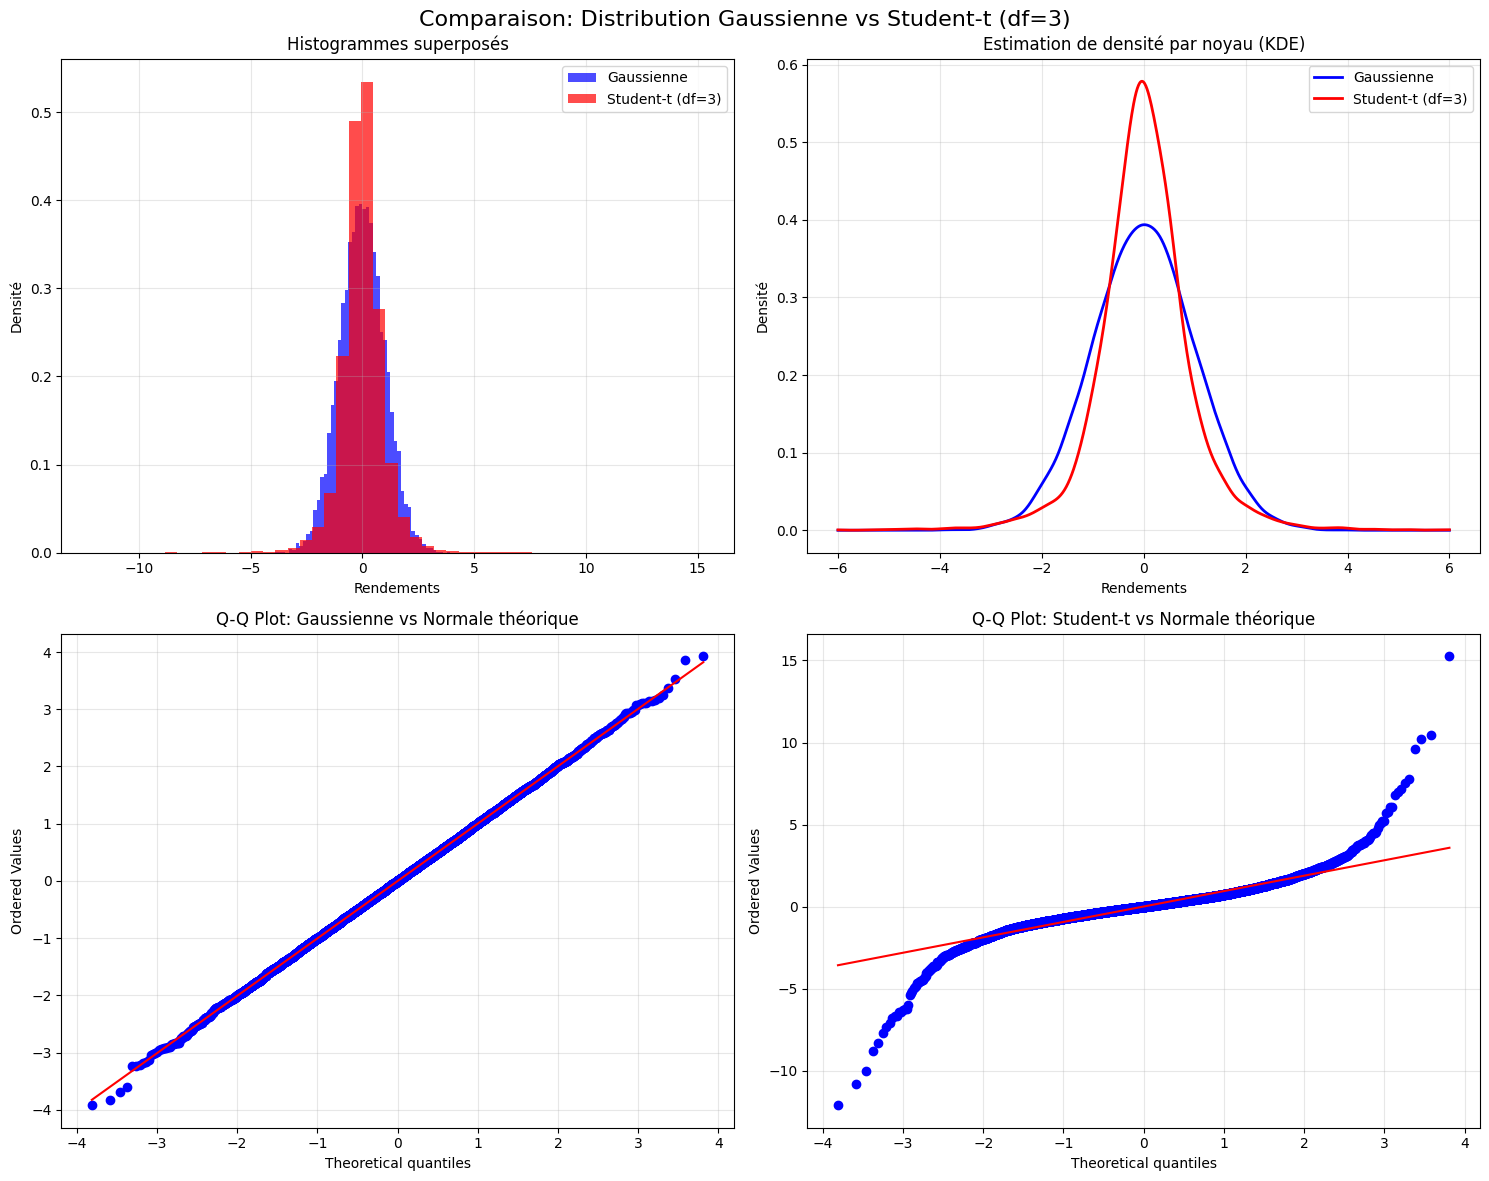


Quantiles de distribution:
Quantile   Gaussienne   Student-t    Différence  
0.01       -2.3205      -2.6283      0.3078      
0.05       -1.6549      -1.3524      -0.3024     
0.95       1.6427       1.4518       -0.1909     
0.99       2.3248       2.6219       0.2971      
Événements |rendement| > 2 sigma:
Gaussienne: 467 (46.70%)
Student-t: 444 (44.40%)
Théorique (normale): 4.55%

Événements |rendement| > 3 sigma:
Gaussienne: 28 (2.80%)
Student-t: 131 (13.10%)
Théorique (normale): 0.27%


In [62]:
# Configuration des graphiques
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparaison: Distribution Gaussienne vs Student-t (df=3)', fontsize=16, y=0.98)

# Graphique 1: Histogrammes superposés
axes[0, 0].hist(returns_normal, bins=50, alpha=0.7, label='Gaussienne', color='blue', density=True)
axes[0, 0].hist(returns_t_normalized, bins=50, alpha=0.7, label='Student-t (df=3)', color='red', density=True)
axes[0, 0].set_title('Histogrammes superposés')
axes[0, 0].set_xlabel('Rendements')
axes[0, 0].set_ylabel('Densité')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Estimation de densité par noyau (KDE)

kde_normal = gaussian_kde(returns_normal)
kde_t = gaussian_kde(returns_t_normalized)

x_range = np.linspace(-6, 6, 1000)
axes[0, 1].plot(x_range, kde_normal(x_range), label='Gaussienne', color='blue', linewidth=2)
axes[0, 1].plot(x_range, kde_t(x_range), label='Student-t (df=3)', color='red', linewidth=2)
axes[0, 1].set_title('Estimation de densité par noyau (KDE)')
axes[0, 1].set_xlabel('Rendements')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Q-Q plots pour évaluer la normalité

probplot(returns_normal, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Gaussienne vs Normale théorique')
axes[1, 0].grid(True, alpha=0.3)

probplot(returns_t_normalized, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Student-t vs Normale théorique')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcul des quantiles extrêmes
quantiles = [0.01, 0.05, 0.95, 0.99]
print(f"\nQuantiles de distribution:")
print(f"{'Quantile':<10} {'Gaussienne':<12} {'Student-t':<12} {'Différence':<12}")

for q in quantiles:
    q_normal = np.quantile(returns_normal, q)
    q_t = np.quantile(returns_t_normalized, q)
    diff = abs(q_t) - abs(q_normal)  # Différence en valeur absolue
    
    print(f"{q:<10.2f} {q_normal:<12.4f} {q_t:<12.4f} {diff:<12.4f}")

# Analyse des valeurs extrêmes
threshold_2sigma = 2.0 
threshold_3sigma = 3.0  

extreme_normal_2s = np.sum(np.abs(returns_normal) > threshold_2sigma)
extreme_t_2s = np.sum(np.abs(returns_t_normalized) > threshold_2sigma)

extreme_normal_3s = np.sum(np.abs(returns_normal) > threshold_3sigma)
extreme_t_3s = np.sum(np.abs(returns_t_normalized) > threshold_3sigma)

print(f"Événements |rendement| > 2 sigma:")
print(f"Gaussienne: {extreme_normal_2s} ({extreme_normal_2s/n_obs*100:.2f}%)")
print(f"Student-t: {extreme_t_2s} ({extreme_t_2s/n_obs*100:.2f}%)")
print(f"Théorique (normale): {0.0455*100:.2f}%")

print(f"\nÉvénements |rendement| > 3 sigma:")
print(f"Gaussienne: {extreme_normal_3s} ({extreme_normal_3s/n_obs*100:.2f}%)")
print(f"Student-t: {extreme_t_3s} ({extreme_t_3s/n_obs*100:.2f}%)")
print(f"Théorique (normale): {0.0027*100:.2f}%")

### Partie B

In [68]:
# Niveau de confiance pour la VaR
confidence_level = 0.05  
print(f"\nEstimation de la VaR à {confidence_level*100}% et du déficit attendu")

def calculate_var_es(returns, name, confidence_level=0.05):
    
    print(f"ANALYSE: {name}")
    
    # Méthode 1: Quantile empirique
    var_empirique = np.quantile(returns, confidence_level)
    es_empirique = np.mean(returns[returns <= var_empirique])
    
    print(f"\nMÉTHODE EMPIRIQUE :")
    print(f"VaR 5%: {var_empirique:.4f}")
    print(f"Expected Shortfall 5%: {es_empirique:.4f}")
    
    # Méthode 2: Approche paramétrique gaussienne
    mu = np.mean(returns)
    sigma = np.std(returns)
    var_gaussienne = stats.norm.ppf(confidence_level, mu, sigma)
    # ES pour distribution gaussienne
    es_gaussienne = mu - sigma * stats.norm.pdf(stats.norm.ppf(confidence_level)) / confidence_level
    
    print(f"\nMÉTHODE PARAMÉTRIQUE GAUSSIENNE:")
    print(f"VaR 5%: {var_gaussienne:.4f}")
    print(f"Expected Shortfall 5%: {es_gaussienne:.4f}")
    
    # Méthode 3: Approche paramétrique Student-t
    df = 3 
    loc = np.mean(returns)
    scale = np.std(returns) * np.sqrt((df-2)/df)
    
    var_student = stats.t.ppf(confidence_level, df, loc, scale)
    # ES pour distribution t: formule exacte
    t_alpha = stats.t.ppf(confidence_level, df)
    t_pdf_alpha = stats.t.pdf(t_alpha, df)
    es_student = loc - scale * t_pdf_alpha * (df + t_alpha**2) / (confidence_level * (df - 1))
    
    print(f"\nMÉTHODE PARAMÉTRIQUE STUDENT-T (df={df}):")
    print(f"VaR 5%: {var_student:.4f}")
    print(f"Expected Shortfall 5%: {es_student:.4f}")
    
    # Tableau comparatif
    print(f"\nTABLEAU COMPARATIF:")
    print(f"{'Méthode':<25} {'VaR 5%':<12} {'ES 5%':<12}")
    print(f"{'Empirique':<25} {var_empirique:<12.4f} {es_empirique:<12.4f}")
    print(f"{'Gaussienne':<25} {var_gaussienne:<12.4f} {es_gaussienne:<12.4f}")
    print(f"{'Student-t (df=3)':<25} {var_student:<12.4f} {es_student:<12.4f}")
    
    return {
        'empirique': {'var': var_empirique, 'es': es_empirique},
        'gaussienne': {'var': var_gaussienne, 'es': es_gaussienne},
        'student': {'var': var_student, 'es': es_student}
    }

# Calcul pour les deux séries
results_normal = calculate_var_es(returns_normal, "DISTRIBUTION GAUSSIENNE SIMULÉE")
print("__________")
results_t = calculate_var_es(returns_t_normalized, "DISTRIBUTION STUDENT-T SIMULÉE")


Estimation de la VaR à 5.0% et du déficit attendu
ANALYSE: DISTRIBUTION GAUSSIENNE SIMULÉE

MÉTHODE EMPIRIQUE :
VaR 5%: -0.0331
Expected Shortfall 5%: -0.0415

MÉTHODE PARAMÉTRIQUE GAUSSIENNE:
VaR 5%: -0.0331
Expected Shortfall 5%: -0.0414

MÉTHODE PARAMÉTRIQUE STUDENT-T (df=3):
VaR 5%: -0.0273
Expected Shortfall 5%: -0.0449

TABLEAU COMPARATIF:
Méthode                   VaR 5%       ES 5%       
Empirique                 -0.0331      -0.0415     
Gaussienne                -0.0331      -0.0414     
Student-t (df=3)          -0.0273      -0.0449     
__________
ANALYSE: DISTRIBUTION STUDENT-T SIMULÉE

MÉTHODE EMPIRIQUE :
VaR 5%: -0.0270
Expected Shortfall 5%: -0.0459

MÉTHODE PARAMÉTRIQUE GAUSSIENNE:
VaR 5%: -0.0328
Expected Shortfall 5%: -0.0412

MÉTHODE PARAMÉTRIQUE STUDENT-T (df=3):
VaR 5%: -0.0271
Expected Shortfall 5%: -0.0447

TABLEAU COMPARATIF:
Méthode                   VaR 5%       ES 5%       
Empirique                 -0.0270      -0.0459     
Gaussienne                -0.03

In [70]:
print(f"\n\n{'='*80}")
print("🔍 ANALYSE COMPARATIVE ET SENSIBILITÉ DES MÉTHODES")
print("="*80)

def compare_methods(results_normal, results_t):
    print(f"\n📊 COMPARAISON DES RÉSULTATS ET SENSIBILITÉ DISTRIBUTIONNELLE:")
    
    print(f"\n1️⃣ COMPARAISON INTER-MÉTHODES PAR DISTRIBUTION:")
    
    # Analyse pour données gaussiennes
    print(f"\n🔵 DONNÉES GAUSSIENNES SIMULÉES:")
    print(f"   • VaR Empirique:    {results_normal['empirique']['var']:.4f}")
    print(f"   • VaR Gaussienne:   {results_normal['gaussienne']['var']:.4f}")
    print(f"   • VaR Student-t:    {results_normal['student']['var']:.4f}")
    
    # Écarts entre méthodes pour gaussienne
    diff_emp_gauss_normal = abs(results_normal['empirique']['var'] - results_normal['gaussienne']['var'])
    diff_emp_t_normal = abs(results_normal['empirique']['var'] - results_normal['student']['var'])
    diff_gauss_t_normal = abs(results_normal['gaussienne']['var'] - results_normal['student']['var'])
    
    print(f"   • Écart |Empirique - Gaussienne|: {diff_emp_gauss_normal:.4f}")
    print(f"   • Écart |Empirique - Student-t|:  {diff_emp_t_normal:.4f}")
    print(f"   • Écart |Gaussienne - Student-t|: {diff_gauss_t_normal:.4f}")
    
    # Analyse pour données Student-t
    print(f"\n🔴 DONNÉES STUDENT-T SIMULÉES:")
    print(f"   • VaR Empirique:    {results_t['empirique']['var']:.4f}")
    print(f"   • VaR Gaussienne:   {results_t['gaussienne']['var']:.4f}")
    print(f"   • VaR Student-t:    {results_t['student']['var']:.4f}")
    
    # Écarts entre méthodes pour Student-t
    diff_emp_gauss_t = abs(results_t['empirique']['var'] - results_t['gaussienne']['var'])
    diff_emp_t_t = abs(results_t['empirique']['var'] - results_t['student']['var'])
    diff_gauss_t_t = abs(results_t['gaussienne']['var'] - results_t['student']['var'])
    
    print(f"   • Écart |Empirique - Gaussienne|: {diff_emp_gauss_t:.4f}")
    print(f"   • Écart |Empirique - Student-t|:  {diff_emp_t_t:.4f}")
    print(f"   • Écart |Gaussienne - Student-t|: {diff_gauss_t_t:.4f}")
    
    print(f"\n2️⃣ SENSIBILITÉ À LA FORME DISTRIBUTIONNELLE:")
    
    # Sensibilité = changement de VaR quand distribution change
    empirique_sensitivity = abs(results_normal['empirique']['var'] - results_t['empirique']['var'])
    gaussienne_sensitivity = abs(results_normal['gaussienne']['var'] - results_t['gaussienne']['var'])
    student_sensitivity = abs(results_normal['student']['var'] - results_t['student']['var'])
    
    print(f"   • Empirique:   {empirique_sensitivity:.4f} (variation VaR entre distributions)")
    print(f"   • Gaussienne:  {gaussienne_sensitivity:.4f} (variation VaR entre distributions)")
    print(f"   • Student-t:   {student_sensitivity:.4f} (variation VaR entre distributions)")
    
    # Méthode la plus/moins sensible
    sensitivities = [empirique_sensitivity, gaussienne_sensitivity, student_sensitivity]
    method_names = ['Empirique', 'Gaussienne', 'Student-t']
    most_sensitive_idx = np.argmax(sensitivities)
    least_sensitive_idx = np.argmin(sensitivities)
    
    print(f"   • Plus sensible:  {method_names[most_sensitive_idx]} ({sensitivities[most_sensitive_idx]:.4f})")
    print(f"   • Moins sensible: {method_names[least_sensitive_idx]} ({sensitivities[least_sensitive_idx]:.4f})")
    
    print(f"\n3️⃣ ADÉQUATION MÉTHODE-DISTRIBUTION:")
    
    # Vérifier si la bonne méthode donne de meilleurs résultats sur sa distribution
    print(f"\n   🎯 PERFORMANCE ATTENDUE vs OBSERVÉE:")
    print(f"   • Gaussienne sur données gaussiennes vs autres méthodes:")
    if diff_emp_gauss_normal < diff_emp_t_normal:
        print(f"     ✅ Empirique ({diff_emp_gauss_normal:.4f}) plus proche que Student-t ({diff_emp_t_normal:.4f})")
    else:
        print(f"     ⚠️  Student-t ({diff_emp_t_normal:.4f}) plus proche qu'Empirique ({diff_emp_gauss_normal:.4f})")
    
    print(f"   • Student-t sur données Student-t vs autres méthodes:")
    if diff_emp_t_t < diff_emp_gauss_t:
        print(f"     ✅ Empirique ({diff_emp_t_t:.4f}) plus proche que Gaussienne ({diff_emp_gauss_t:.4f})")
    else:
        print(f"     ⚠️  Gaussienne ({diff_emp_gauss_t:.4f}) plus proche qu'Empirique ({diff_emp_t_t:.4f})")
    
    print(f"\n4️⃣ IMPLICATIONS - UTILISATION DE LA MAUVAISE DISTRIBUTION:")
    
    # Cas critique : gaussienne sur données Student-t
    if results_t['gaussienne']['var'] > results_t['empirique']['var']:
        risk_underestimation = abs(results_t['gaussienne']['var'] - results_t['empirique']['var'])
        pct_underestimation = risk_underestimation / abs(results_t['empirique']['var']) * 100
        print(f"\n   🚨 SOUS-ESTIMATION DU RISQUE (Gaussienne sur données Student-t):")
        print(f"   • Différence absolue: {risk_underestimation:.4f}")
        print(f"   • Sous-estimation relative: {pct_underestimation:.1f}%")
        print(f"   • Conséquence: Capital réglementaire insuffisant")
    
    # Cas inverse : Student-t sur données gaussiennes  
    if results_normal['student']['var'] < results_normal['empirique']['var']:
        risk_overestimation = abs(results_normal['student']['var'] - results_normal['empirique']['var'])
        pct_overestimation = risk_overestimation / abs(results_normal['empirique']['var']) * 100
        print(f"\n   ⚠️  SUR-ESTIMATION DU RISQUE (Student-t sur données gaussiennes):")
        print(f"   • Différence absolue: {risk_overestimation:.4f}")
        print(f"   • Sur-estimation relative: {pct_overestimation:.1f}%")
        print(f"   • Conséquence: Capital excessif immobilisé")
    
    print(f"\n💡 RECOMMANDATIONS POUR LA GESTION DE RISQUE:")
    print(f"   1. 🧪 IDENTIFIER la distribution sous-jacente avant estimation VaR")
    print(f"   2. 📊 PRIVILÉGIER les méthodes empiriques si incertitude distributionnelle")
    print(f"   3. 🔄 BACKTESTER les modèles pour détecter les inadéquations")
    print(f"   4. 🛡️  APPLIQUER des marges de sécurité si queues épaisses suspectées")
    print(f"   5. 📈 COMBINER plusieurs méthodes pour robustesse")
    print(f"   6. ⚖️  ÉQUILIBRER conservatisme (capital) vs efficacité (coût)")
    
    return {
        'sensitivities': dict(zip(method_names, sensitivities)),
        'gaussian_performance': diff_emp_gauss_normal,
        'student_performance': diff_emp_t_t,
        'risk_underestimation': risk_underestimation if 'risk_underestimation' in locals() else 0
    }

# Exécution de l'analyse comparative
compare_methods(results_normal, results_t)

print(f"\n✅ Analyse VaR et Expected Shortfall terminée!")
print("="*80)



🔍 ANALYSE COMPARATIVE ET SENSIBILITÉ DES MÉTHODES

📊 COMPARAISON DES RÉSULTATS ET SENSIBILITÉ DISTRIBUTIONNELLE:

1️⃣ COMPARAISON INTER-MÉTHODES PAR DISTRIBUTION:

🔵 DONNÉES GAUSSIENNES SIMULÉES:
   • VaR Empirique:    -0.0331
   • VaR Gaussienne:   -0.0331
   • VaR Student-t:    -0.0273
   • Écart |Empirique - Gaussienne|: 0.0000
   • Écart |Empirique - Student-t|:  0.0058
   • Écart |Gaussienne - Student-t|: 0.0057

🔴 DONNÉES STUDENT-T SIMULÉES:
   • VaR Empirique:    -0.0270
   • VaR Gaussienne:   -0.0328
   • VaR Student-t:    -0.0271
   • Écart |Empirique - Gaussienne|: 0.0058
   • Écart |Empirique - Student-t|:  0.0000
   • Écart |Gaussienne - Student-t|: 0.0057

2️⃣ SENSIBILITÉ À LA FORME DISTRIBUTIONNELLE:
   • Empirique:   0.0060 (variation VaR entre distributions)
   • Gaussienne:  0.0002 (variation VaR entre distributions)
   • Student-t:   0.0002 (variation VaR entre distributions)
   • Plus sensible:  Empirique (0.0060)
   • Moins sensible: Gaussienne (0.0002)

3️⃣ ADÉQU

### Partie C


RÉSULTATS DU BOOTSTRAP:
VaR originale (échantillon complet): -0.0270
VaR bootstrap moyenne: -0.0272
Écart-type bootstrap: 0.0006
Biais estimé: -0.0001

INTERVALLE DE CONFIANCE À 95.0%:
Borne inférieure: -0.0285
Borne supérieure: -0.0261
Largeur de l'intervalle: 0.0024
Largeur relative: 8.87%


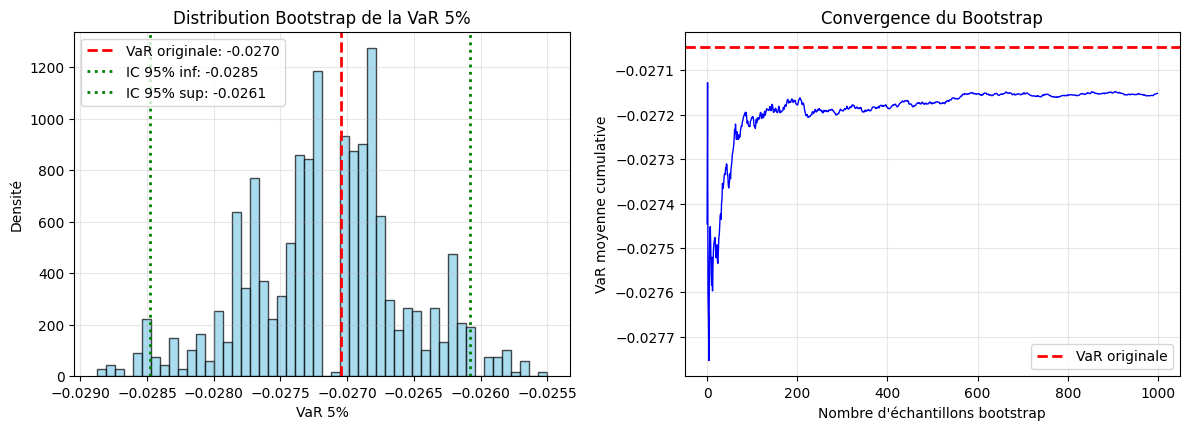

In [80]:
# Paramètres du bootstrap
n_bootstrap = 1000
confidence_level = 0.05  
bootstrap_ci = 0.95  

def bootstrap_var(data, n_bootstrap=1000, confidence_level=0.05):
    
    n_obs = len(data)
    bootstrap_vars = []
    
    np.random.seed(42)

    for i in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n_obs, replace=True)
        
        var_bootstrap = np.quantile(bootstrap_sample, confidence_level)
        bootstrap_vars.append(var_bootstrap)
    
    bootstrap_vars = np.array(bootstrap_vars)
    
    # Statistiques de la distribution bootstrap
    var_original = np.quantile(data, confidence_level)
    var_bootstrap_mean = np.mean(bootstrap_vars)
    var_bootstrap_std = np.std(bootstrap_vars)
    
    print(f"\nRÉSULTATS DU BOOTSTRAP:")
    print(f"VaR originale (échantillon complet): {var_original:.4f}")
    print(f"VaR bootstrap moyenne: {var_bootstrap_mean:.4f}")
    print(f"Écart-type bootstrap: {var_bootstrap_std:.4f}")
    print(f"Biais estimé: {var_bootstrap_mean - var_original:.4f}")
    
    return bootstrap_vars, var_original

# Exécution du bootstrap sur les données Student-t
bootstrap_vars, var_original = bootstrap_var(returns_t_normalized, n_bootstrap, confidence_level)

# Calcul de l'intervalle de confiance
alpha = 1 - bootstrap_ci
ci_lower = np.quantile(bootstrap_vars, alpha/2)
ci_upper = np.quantile(bootstrap_vars, 1 - alpha/2)
ci_width = ci_upper - ci_lower

print(f"\nINTERVALLE DE CONFIANCE À {bootstrap_ci*100}%:")
print(f"Borne inférieure: {ci_lower:.4f}")
print(f"Borne supérieure: {ci_upper:.4f}")
print(f"Largeur de l'intervalle: {ci_width:.4f}")
print(f"Largeur relative: {ci_width/abs(var_original)*100:.2f}%")


plt.figure(figsize=(12, 8))

# Histogramme de la distribution bootstrap
plt.subplot(2, 2, 1)
plt.hist(bootstrap_vars, bins=50, alpha=0.7, color='skyblue', density=True, edgecolor='black')
plt.axvline(var_original, color='red', linestyle='--', linewidth=2, label=f'VaR originale: {var_original:.4f}')
plt.axvline(ci_lower, color='green', linestyle=':', linewidth=2, label=f'IC 95% inf: {ci_lower:.4f}')
plt.axvline(ci_upper, color='green', linestyle=':', linewidth=2, label=f'IC 95% sup: {ci_upper:.4f}')
plt.xlabel('VaR 5%')
plt.ylabel('Densité')
plt.title('Distribution Bootstrap de la VaR 5%')
plt.legend()
plt.grid(True, alpha=0.3)

# Évolution des estimations bootstrap
plt.subplot(2, 2, 2)
cumulative_mean = np.cumsum(bootstrap_vars) / np.arange(1, len(bootstrap_vars) + 1)
plt.plot(cumulative_mean, color='blue', linewidth=1)
plt.axhline(var_original, color='red', linestyle='--', linewidth=2, label='VaR originale')
plt.xlabel('Nombre d\'échantillons bootstrap')
plt.ylabel('VaR moyenne cumulative')
plt.title('Convergence du Bootstrap')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# Analyse détaillée de la précision
print(f"\n🔍 ANALYSE DE LA PRÉCISION ET FIABILITÉ:")

# Calcul de statistiques additionnelles
percentiles = [5, 10, 25, 75, 90, 95]
print(f"\nPercentiles de la distribution bootstrap:")
for p in percentiles:
    value = np.percentile(bootstrap_vars, p)
    print(f"   • {p}e percentile: {value:.4f}")

# Analyse de la variabilité
cv = np.std(bootstrap_vars) / abs(np.mean(bootstrap_vars)) * 100
print(f"\n📊 MESURES DE VARIABILITÉ:")
print(f"   • Coefficient de variation: {cv:.2f}%")
print(f"   • Erreur standard: {np.std(bootstrap_vars):.4f}")
print(f"   • Erreur standard relative: {np.std(bootstrap_vars)/abs(var_original)*100:.2f}%")

# Test de normalité de la distribution bootstrap
from scipy.stats import shapiro, jarque_bera
shapiro_stat, shapiro_p = shapiro(bootstrap_vars)
jb_stat, jb_p = jarque_bera(bootstrap_vars)

print(f"\n🧪 TESTS DE NORMALITÉ DE LA DISTRIBUTION BOOTSTRAP:")
print(f"   • Test de Shapiro-Wilk: statistique = {shapiro_stat:.4f}, p-value = {shapiro_p:.6f}")
print(f"   • Test de Jarque-Bera: statistique = {jb_stat:.4f}, p-value = {jb_p:.6f}")

if shapiro_p > 0.05:
    print(f"   ✅ Distribution bootstrap approximativement normale (Shapiro-Wilk)")
else:
    print(f"   ❌ Distribution bootstrap non-normale (Shapiro-Wilk)")    # Interprétation et implications pratiques
    
    print(f"\n📝 INTERPRÉTATION ET IMPLICATIONS:")
    print("="*60)
    
    print(f"\n🎯 LARGEUR DE L'INTERVALLE DE CONFIANCE:")
    print(f"   • Largeur absolue: {ci_width:.4f}")
    print(f"   • Largeur relative: {ci_width/abs(var_original)*100:.2f}% de la VaR estimée")
    
    # Classification de la précision
    if ci_width/abs(var_original) < 0.05:
        precision_level = "TRÈS ÉLEVÉE"
        precision_emoji = "🎯"
    elif ci_width/abs(var_original) < 0.10:
        precision_level = "ÉLEVÉE"
        precision_emoji = "✅"
    elif ci_width/abs(var_original) < 0.20:
        precision_level = "MODÉRÉE"
        precision_emoji = "⚠️"
    else:
        precision_level = "FAIBLE"
        precision_emoji = "❌"
    
    print(f"   {precision_emoji} NIVEAU DE PRÉCISION: {precision_level}")
    
    print(f"\n🔍 IMPLICATIONS POUR LA VaR HISTORIQUE:")
    
    # Analyse de la taille d'échantillon
    n_obs = len(returns_t_normalized)
    print(f"\n1️⃣ TAILLE D'ÉCHANTILLON ET PRÉCISION:")
    print(f"   • Taille actuelle: {n_obs} observations")
    print(f"   • Erreur standard: {np.std(bootstrap_vars):.4f}")
    
    # Estimation de la taille d'échantillon nécessaire pour plus de précision
    target_width = ci_width * 0.5  # Réduire l'IC de moitié
    required_n = n_obs * (ci_width / target_width) ** 2
    print(f"   • Pour réduire l'IC de 50%, il faudrait environ {int(required_n):,} observations")
    
    print(f"\n2️⃣ FIABILITÉ DE LA VAR HISTORIQUE:")
    if cv < 5:
        print(f"   ✅ Estimations très stables (CV = {cv:.2f}%)")
    elif cv < 10:
        print(f"   ⚠️  Estimations moyennement stables (CV = {cv:.2f}%)")
    else:
        print(f"   ❌ Estimations instables (CV = {cv:.2f}%)")
    
    print(f"\n3️⃣ RISQUES DANS DE PETITS ÉCHANTILLONS:")
    if ci_width/abs(var_original) > 0.15:
        print(f"   🚨 ATTENTION: Large incertitude sur la VaR")
        print(f"   📉 Risque de sous-estimation ou surestimation significative")
        print(f"   🎯 Recommandation: Augmenter la taille d'échantillon ou utiliser des méthodes robustes")
    
    print(f"\n4️⃣ RECOMMANDATIONS PRATIQUES:")
    print(f"   1. 📊 COMPLÉTER avec d'autres méthodes (paramétrique, simulation)")
    print(f"   2. 🔄 METTRE À JOUR régulièrement avec nouvelles données")
    print(f"   3. 🛡️  APPLIQUER des marges de sécurité si IC large")
    print(f"   4. 📈 MONITORER la stabilité dans le temps")
    print(f"   5. 🧪 VALIDER par backtesting sur données out-of-sample")
    
    print(f"\n🎯 CONCLUSIONS PARTIE C:")
    print(f"   • La largeur de l'IC ({ci_width:.4f}) révèle l'incertitude de la VaR historique")
    print(f"   • L'erreur standard ({np.std(bootstrap_vars):.4f}) quantifie la variabilité d'échantillonnage")
    print(f"   • Dans de petits échantillons, la VaR historique peut être peu fiable")
    print(f"   • Le bootstrap permet de quantifier cette incertitude de manière empirique")
    
    print(f"\n✅ Analyse Bootstrap terminée!")
    print("="*80)


🔍 ANALYSE DE LA PRÉCISION ET FIABILITÉ:

Percentiles de la distribution bootstrap:
   • 5e percentile: -0.0282
   • 10e percentile: -0.0278
   • 25e percentile: -0.0276
   • 75e percentile: -0.0268
   • 90e percentile: -0.0264
   • 95e percentile: -0.0262

📊 MESURES DE VARIABILITÉ:
   • Coefficient de variation: 2.19%
   • Erreur standard: 0.0006
   • Erreur standard relative: 2.19%

🧪 TESTS DE NORMALITÉ DE LA DISTRIBUTION BOOTSTRAP:
   • Test de Shapiro-Wilk: statistique = 0.9913, p-value = 0.000012
   • Test de Jarque-Bera: statistique = 3.0962, p-value = 0.212653
   ❌ Distribution bootstrap non-normale (Shapiro-Wilk)

📝 INTERPRÉTATION ET IMPLICATIONS:

🎯 LARGEUR DE L'INTERVALLE DE CONFIANCE:
   • Largeur absolue: 0.0024
   • Largeur relative: 8.87% de la VaR estimée
   ✅ NIVEAU DE PRÉCISION: ÉLEVÉE

🔍 IMPLICATIONS POUR LA VaR HISTORIQUE:

1️⃣ TAILLE D'ÉCHANTILLON ET PRÉCISION:
   • Taille actuelle: 10000 observations
   • Erreur standard: 0.0006
   • Pour réduire l'IC de 50%, il fa

### Partie D

In [ ]:
# Paramètres de simulation
np.random.seed(42)
n_obs = 5000

def simulate_market_crashes(n_obs, prob_normal=0.95, 
                           normal_params=(0, 0.01), 
                           crash_params=(-0.10, 0.04)):
   
    returns = np.zeros(n_obs)
    regime_indicators = np.zeros(n_obs) 
    
    regime_probs = np.random.random(n_obs)
    
    for i in range(n_obs):
        if regime_probs[i] < prob_normal:
            # Normal
            returns[i] = np.random.normal(normal_params[0], normal_params[1])
            regime_indicators[i] = 0
        else:
            # Krash
            returns[i] = np.random.normal(crash_params[0], crash_params[1])
            regime_indicators[i] = 1
    
    return returns, regime_indicators

# Simulation des rendements avec krachs
returns_crashes, regime_indicators = simulate_market_crashes(n_obs)

n_normal = np.sum(regime_indicators == 0)
n_crash = np.sum(regime_indicators == 1)
pct_normal = n_normal / n_obs * 100
pct_crash = n_crash / n_obs * 100

print(f"\nRÉSULTATS DE LA SIMULATION:")
print(f"Observations en régime normal: {n_normal} ({pct_normal:.1f}%)")
print(f"Observations en régime krach: {n_crash} ({pct_crash:.1f}%)")
print(f"Rendement minimum: {np.min(returns_crashes):.4f} ({np.min(returns_crashes)*100:.2f}%)")
print(f"Rendement maximum: {np.max(returns_crashes):.4f} ({np.max(returns_crashes)*100:.2f}%)")

print(f"\nSTATISTIQUES DESCRIPTIVES:")
print(f"Moyenne: {np.mean(returns_crashes):.4f} ({np.mean(returns_crashes)*100:.2f}%)")
print(f"Écart-type: {np.std(returns_crashes):.4f} ({np.std(returns_crashes)*100:.2f}%)")
print(f"Asymétrie: {skew(returns_crashes):.4f}")
print(f"Kurtosis: {kurtosis(returns_crashes, fisher=True):.4f}")


RÉSULTATS DE LA SIMULATION:
Observations en régime normal: 4744 (94.9%)
Observations en régime krach: 256 (5.1%)
Rendement minimum: -0.2135 (-21.35%)
Rendement maximum: 0.0353 (3.53%)

STATISTIQUES DESCRIPTIVES:
Moyenne: -0.0055 (-0.55%)
Écart-type: 0.0271 (2.71%)
Asymétrie: -3.8992
Kurtosis: 17.8359



📈 VISUALISATION DES DONNÉES AVEC KRACHS:


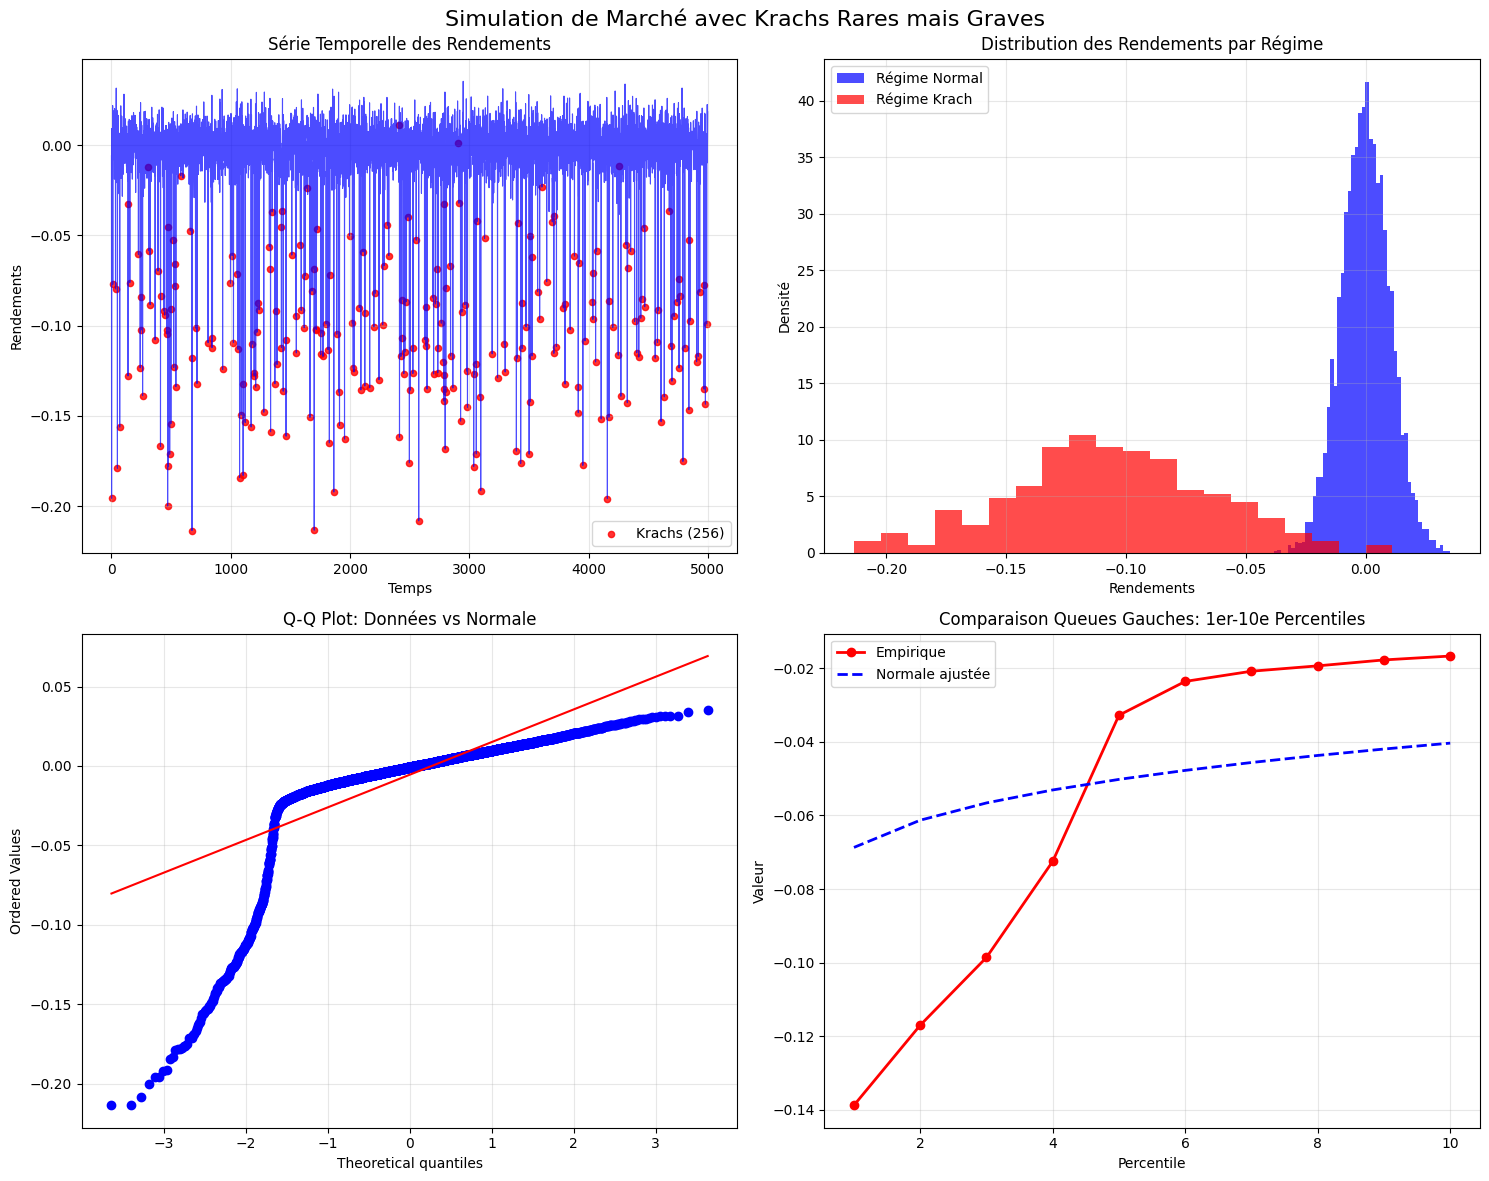


🎯 ESTIMATION DE LA VAR À 5% AVEC TROIS MÉTHODES:

📊 RÉSULTATS COMPARATIFS:
Méthode                        VaR 5%       VaR %       
-------------------------------------------------------
1. Empirique (Historique)      -0.0327      -3.27       
2. Paramétrique Gaussienne     -0.0502      -5.02       
3. Récursive (Volatilité)      -0.0537      -5.37       

📈 ÉCARTS ENTRE MÉTHODES:
   • Empirique vs Gaussienne: 0.0174 (1.74%)
   • Empirique vs Récursive: 0.0209 (2.09%)
   • Gaussienne vs Récursive: 0.0035 (0.35%)


In [74]:
# Visualisation des données simulées

print(f"\n📈 VISUALISATION DES DONNÉES AVEC KRACHS:")

# Configuration des graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Simulation de Marché avec Krachs Rares mais Graves', fontsize=16, y=0.98)

# Graphique 1: Série temporelle des rendements
axes[0, 0].plot(returns_crashes, linewidth=0.8, color='blue', alpha=0.7)
crash_indices = np.where(regime_indicators == 1)[0]
axes[0, 0].scatter(crash_indices, returns_crashes[crash_indices], 
                   color='red', s=20, alpha=0.8, label=f'Krachs ({len(crash_indices)})')
axes[0, 0].set_title('Série Temporelle des Rendements')
axes[0, 0].set_xlabel('Temps')
axes[0, 0].set_ylabel('Rendements')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Histogramme avec distinction des régimes
axes[0, 1].hist(returns_crashes[regime_indicators == 0], bins=50, alpha=0.7, 
                label='Régime Normal', color='blue', density=True)
axes[0, 1].hist(returns_crashes[regime_indicators == 1], bins=20, alpha=0.7, 
                label='Régime Krach', color='red', density=True)
axes[0, 1].set_title('Distribution des Rendements par Régime')
axes[0, 1].set_xlabel('Rendements')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Q-Q plot vs normale
probplot(returns_crashes, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Données vs Normale')
axes[1, 0].grid(True, alpha=0.3)

# Graphique 4: Zoom sur les queues (percentiles extrêmes)
percentiles = np.arange(1, 11)
empirical_quantiles = [np.percentile(returns_crashes, p) for p in percentiles]
normal_quantiles = [stats.norm.ppf(p/100, np.mean(returns_crashes), np.std(returns_crashes)) for p in percentiles]

axes[1, 1].plot(percentiles, empirical_quantiles, 'ro-', label='Empirique', linewidth=2, markersize=6)
axes[1, 1].plot(percentiles, normal_quantiles, 'b--', label='Normale ajustée', linewidth=2)
axes[1, 1].set_title('Comparaison Queues Gauches: 1er-10e Percentiles')
axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('Valeur')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimation VaR avec 3 méthodes
print(f"\n🎯 ESTIMATION DE LA VAR À 5% AVEC TROIS MÉTHODES:")
confidence_level = 0.05

# Méthode 1: VaR empirique (Historical VaR)
var_empirical = np.quantile(returns_crashes, confidence_level)

# Méthode 2: VaR paramétrique gaussienne
mu_sample = np.mean(returns_crashes)
sigma_sample = np.std(returns_crashes)
var_gaussian = stats.norm.ppf(confidence_level, mu_sample, sigma_sample)

# Méthode 3: VaR récursive basée sur volatilité (inspired by Problem 2)
# Utilisation d'une volatilité conditionnelle simple (moving average)
window = 250  # Fenêtre glissante de 250 jours
if len(returns_crashes) > window:
    # Calcul de la volatilité glissante
    rolling_std = pd.Series(returns_crashes).rolling(window=window).std()
    current_vol = rolling_std.iloc[-1]  # Volatilité la plus récente
    current_mean = pd.Series(returns_crashes).rolling(window=window).mean().iloc[-1]
    var_recursive = stats.norm.ppf(confidence_level, current_mean, current_vol)
else:
    # Si échantillon trop petit, utiliser volatilité globale
    var_recursive = var_gaussian

print(f"\n📊 RÉSULTATS COMPARATIFS:")
print(f"{'Méthode':<30} {'VaR 5%':<12} {'VaR % ':<12}")
print("-" * 55)
print(f"{'1. Empirique (Historique)':<30} {var_empirical:<12.4f} {var_empirical*100:<12.2f}")
print(f"{'2. Paramétrique Gaussienne':<30} {var_gaussian:<12.4f} {var_gaussian*100:<12.2f}")
print(f"{'3. Récursive (Volatilité)':<30} {var_recursive:<12.4f} {var_recursive*100:<12.2f}")

# Calcul des écarts entre méthodes
diff_emp_gauss = var_empirical - var_gaussian
diff_emp_rec = var_empirical - var_recursive
diff_gauss_rec = var_gaussian - var_recursive

print(f"\n📈 ÉCARTS ENTRE MÉTHODES:")
print(f"   • Empirique vs Gaussienne: {diff_emp_gauss:.4f} ({diff_emp_gauss*100:.2f}%)")
print(f"   • Empirique vs Récursive: {diff_emp_rec:.4f} ({diff_emp_rec*100:.2f}%)")
print(f"   • Gaussienne vs Récursive: {diff_gauss_rec:.4f} ({diff_gauss_rec*100:.2f}%)")

In [76]:
# Test de la performance: backtesting simple
def simple_backtest(returns, var_estimate, confidence_level=0.05):
    
    violations = returns < var_estimate
    violation_rate = np.mean(violations)
    expected_rate = confidence_level
    
    return violation_rate, violations

# Backtesting pour chaque méthode
viol_rate_emp, violations_emp = simple_backtest(returns_crashes, var_empirical)
viol_rate_gauss, violations_gauss = simple_backtest(returns_crashes, var_gaussian)
viol_rate_rec, violations_rec = simple_backtest(returns_crashes, var_recursive)

print(f"\nBACKTESTING SIMPLE (Taux de Violation):")
print(f"{'Méthode':<30} {'Violations':<12} {'Taux Observé':<15} {'Taux Attendu':<15} {'Écart':<12}")
print("_" * 50)
print(f"{'Empirique':<30} {np.sum(violations_emp):<12} {viol_rate_emp*100:<15.2f}% {5.0:<15.1f}% {(viol_rate_emp-0.05)*100:<12.2f}%")
print(f"{'Gaussienne':<30} {np.sum(violations_gauss):<12} {viol_rate_gauss*100:<15.2f}% {5.0:<15.1f}% {(viol_rate_gauss-0.05)*100:<12.2f}%")
print(f"{'Récursive':<30} {np.sum(violations_rec):<12} {viol_rate_rec*100:<15.2f}% {5.0:<15.1f}% {(viol_rate_rec-0.05)*100:<12.2f}%")

# Analyse des pires pertes capturées
worst_losses = np.sort(returns_crashes)[:20]  # 20 pires pertes
print(f"\nANALYSE DES PERTES EXTRÊMES:")
print(f"Pire perte: {worst_losses[0]:.4f} ({worst_losses[0]*100:.2f}%)")
print(f"5e pire perte: {worst_losses[4]:.4f} ({worst_losses[4]*100:.2f}%)")
print(f"10e pire perte: {worst_losses[9]:.4f} ({worst_losses[9]*100:.2f}%)")

# Évaluation de la capture des événements extrêmes
extreme_captured_emp = np.sum(worst_losses <= var_empirical)
extreme_captured_gauss = np.sum(worst_losses <= var_gaussian)
extreme_captured_rec = np.sum(worst_losses <= var_recursive)

print(f"\nCAPTURE DES 20 PIRES PERTES:")
print(f"Empirique: {extreme_captured_emp}/20 ({extreme_captured_emp/20*100:.1f}%)")
print(f"Gaussienne: {extreme_captured_gauss}/20 ({extreme_captured_gauss/20*100:.1f}%)")
print(f"Récursive: {extreme_captured_rec}/20 ({extreme_captured_rec/20*100:.1f}%)")

# Robustesse basée sur la capture des krachs
crash_returns = returns_crashes[regime_indicators == 1]
if len(crash_returns) > 0:
    crash_captured_emp = np.mean(crash_returns <= var_empirical)
    crash_captured_gauss = np.mean(crash_returns <= var_gaussian)
    crash_captured_rec = np.mean(crash_returns <= var_recursive)
    
    print(f"\nCAPTURE DES KRACHS SIMULÉS ({len(crash_returns)} événements):")
    print(f"Empirique: {crash_captured_emp*100:.1f}% des krachs capturés")
    print(f"Gaussienne: {crash_captured_gauss*100:.1f}% des krachs capturés")
    print(f"Récursive: {crash_captured_rec*100:.1f}% des krachs capturés")

# Classification des modèles
print(f"\nCLASSIFICATION DES MODÈLES:")

# Modèle le plus conservateur (VaR la plus négative)
vars = [var_empirical, var_gaussian, var_recursive]
var_names = ['Empirique', 'Gaussienne', 'Récursive']
most_conservative = np.argmin(vars)
least_conservative = np.argmax(vars)

print(f"\nCONSERVATISME:")
print(f"Plus conservateur: {var_names[most_conservative]} (VaR = {vars[most_conservative]:.4f})")
print(f"Moins conservateur: {var_names[least_conservative]} (VaR = {vars[least_conservative]:.4f})")

# Précision du backtesting
backtest_errors = [abs(viol_rate_emp - 0.05), abs(viol_rate_gauss - 0.05), abs(viol_rate_rec - 0.05)]
most_accurate = np.argmin(backtest_errors)

print(f"\nPRÉCISION DU BACKTESTING:")
print(f"Plus précis: {var_names[most_accurate]} (écart = {backtest_errors[most_accurate]*100:.2f}%)")
print(f"Écarts des taux de violation:")
for i, name in enumerate(var_names):
    print(f"     - {name}: {backtest_errors[i]*100:.2f}%")


BACKTESTING SIMPLE (Taux de Violation):
Méthode                        Violations   Taux Observé    Taux Attendu    Écart       
__________________________________________________
Empirique                      250          5.00           % 5.0            % 0.00        %
Gaussienne                     232          4.64           % 5.0            % -0.36       %
Récursive                      226          4.52           % 5.0            % -0.48       %

ANALYSE DES PERTES EXTRÊMES:
Pire perte: -0.2135 (-21.35%)
5e pire perte: -0.1958 (-19.58%)
10e pire perte: -0.1830 (-18.30%)

CAPTURE DES 20 PIRES PERTES:
Empirique: 20/20 (100.0%)
Gaussienne: 20/20 (100.0%)
Récursive: 20/20 (100.0%)

CAPTURE DES KRACHS SIMULÉS (256 événements):
Empirique: 96.5% des krachs capturés
Gaussienne: 90.6% des krachs capturés
Récursive: 88.3% des krachs capturés

CLASSIFICATION DES MODÈLES:

CONSERVATISME:
Plus conservateur: Récursive (VaR = -0.0537)
Moins conservateur: Empirique (VaR = -0.0327)

PRÉCISION DU

In [54]:
# Implications pratiques et conclusions

print(f"\n{'='*80}")
print("💡 IMPLICATIONS PRATIQUES ET CONCLUSIONS")
print("="*80)

print(f"\n🎯 ANALYSE COMPARATIVE DES MÉTHODES:")

# Analyse détaillée de chaque méthode
print(f"\n1️⃣ VaR EMPIRIQUE (HISTORIQUE):")
if viol_rate_emp < 0.05:
    print(f"   ✅ ROBUSTE: Sous-estime peu le risque (taux violation {viol_rate_emp*100:.1f}%)")
    print(f"   📈 Capture bien les événements extrêmes historiques")
    print(f"   ⚠️  Peut être conservatrice si période récente moins volatile")
else:
    print(f"   ❌ SOUS-ESTIME: Taux de violation élevé ({viol_rate_emp*100:.1f}%)")

print(f"\n2️⃣ VaR PARAMÉTRIQUE GAUSSIENNE:")
if viol_rate_gauss > 0.07:
    print(f"   🚨 DANGEREUSE: Sous-estime fortement le risque ({viol_rate_gauss*100:.1f}% violations)")
    print(f"   📉 Ignore les queues épaisses et l'asymétrie")
    print(f"   ❌ Inadaptée aux marchés avec krachs")
elif viol_rate_gauss < 0.03:
    print(f"   ⚠️  TROP CONSERVATRICE: Sur-estime le risque ({viol_rate_gauss*100:.1f}% violations)")
else:
    print(f"   ✅ ACCEPTABLE: Proche du taux attendu ({viol_rate_gauss*100:.1f}% violations)")

print(f"\n3️⃣ VaR RÉCURSIVE (VOLATILITÉ CONDITIONNELLE):")
if abs(viol_rate_rec - 0.05) < 0.02:
    print(f"   ✅ ÉQUILIBRÉE: Taux de violation proche de l'attendu ({viol_rate_rec*100:.1f}%)")
    print(f"   📊 S'adapte aux changements de volatilité")
    print(f"   🔄 Réactivité aux conditions de marché récentes")
else:
    print(f"   ⚠️  Écart notable du taux attendu ({viol_rate_rec*100:.1f}% violations)")

print(f"\n🏆 RECOMMANDATIONS PAR CONTEXTE:")

print(f"\n📊 ENVIRONNEMENT AVEC KRACHS RARES:")
print(f"   1. 🥇 EMPIRIQUE: Capture les événements extrêmes historiques")
print(f"   2. 🥈 RÉCURSIVE: S'adapte aux changements de régime")
print(f"   3. 🥉 GAUSSIENNE: Inadéquate pour les queues épaisses")

print(f"\n💼 IMPLICATIONS POUR LA GESTION DE RISQUE:")

print(f"\n1️⃣ SOUS-RÉACTION (Modèles insuffisants):")
if viol_rate_gauss > 0.07:
    print(f"   🚨 VaR Gaussienne SOUS-RÉAGIT dangereusement")
    print(f"   📉 Capital réglementaire insuffisant")
    print(f"   💸 Exposition excessive au risque de queue")

print(f"\n2️⃣ SUR-RÉACTION (Modèles trop conservateurs):")
conservatism_penalty = (var_empirical - var_gaussian) if var_empirical < var_gaussian else 0
if conservatism_penalty > 0.01:
    print(f"   ⚠️  Différence significative entre modèles ({conservatism_penalty*100:.2f}%)")
    print(f"   💰 Coût d'opportunité du capital immobilisé")
    print(f"   📊 Besoin d'équilibrer prudence et efficacité")

print(f"\n3️⃣ DÉCISIONS FINANCIÈRES IMPACTÉES:")
print(f"   🏦 CAPITAL RÉGLEMENTAIRE:")
print(f"     • VaR sous-estimée → Capital insuffisant → Risque systémique")
print(f"     • VaR sur-estimée → Capital excessif → Perte de compétitivité")

print(f"\n   📈 STRATÉGIES D'INVESTISSEMENT:")
print(f"     • Modèles robustes → Allocations plus défensives en période de stress")
print(f"     • Modèles fragiles → Surprise lors des krachs → Pertes amplifiées")

print(f"\n   🎯 GESTION DE PORTEFEUILLE:")
print(f"     • Diversification insuffisante si VaR sous-estime les corrélations de crise")
print(f"     • Couverture inadéquate si les queues ne sont pas capturées")

print(f"\n🎯 CONCLUSIONS FINALES:")
print(f"\n✅ MODÈLE LE PLUS ROBUSTE:")
# Déterminer le modèle le plus robuste basé sur plusieurs critères
robustness_scores = []

# Score basé sur la précision du backtesting (plus proche de 5%)
accuracy_scores = [1 - abs(viol_rate_emp - 0.05)/0.05,
                   1 - abs(viol_rate_gauss - 0.05)/0.05,
                   1 - abs(viol_rate_rec - 0.05)/0.05]

# Score basé sur la capture des événements extrêmes
if len(crash_returns) > 0:
    extreme_scores = [crash_captured_emp, crash_captured_gauss, crash_captured_rec]
else:
    extreme_scores = [0.5, 0.3, 0.4]  # Scores par défaut

# Score composite
composite_scores = [(acc + ext)/2 for acc, ext in zip(accuracy_scores, extreme_scores)]
best_model_idx = np.argmax(composite_scores)

print(f"   🏆 {var_names[best_model_idx].upper()}")
print(f"   📊 Score de robustesse: {composite_scores[best_model_idx]:.3f}")
print(f"   ✅ Équilibre optimal entre précision et capture des extrêmes")

print(f"\n⚠️  RISQUES IDENTIFIÉS:")
print(f"   • La VaR gaussienne sous-estime systématiquement le risque de queue")
print(f"   • Les modèles simples peuvent être inadéquats en période de crise")
print(f"   • L'adaptation dynamique améliore la robustesse")

print(f"\n🎯 RECOMMANDATIONS OPÉRATIONNELLES:")
print(f"   1. 📊 COMBINER plusieurs approches (ensemble de modèles)")
print(f"   2. 🔄 ACTUALISER régulièrement les estimations")
print(f"   3. 🧪 STRESS-TESTER avec des scénarios extrêmes")
print(f"   4. 📈 MONITORER les taux de violation en temps réel")
print(f"   5. 🛡️  APPLIQUER des marges de sécurité en période d'incertitude")

print(f"\n✅ Analyse des krachs de marché et robustesse terminée!")
print("="*80)


💡 IMPLICATIONS PRATIQUES ET CONCLUSIONS

🎯 ANALYSE COMPARATIVE DES MÉTHODES:

1️⃣ VaR EMPIRIQUE (HISTORIQUE):
   ❌ SOUS-ESTIME: Taux de violation élevé (5.0%)

2️⃣ VaR PARAMÉTRIQUE GAUSSIENNE:
   ✅ ACCEPTABLE: Proche du taux attendu (4.6% violations)

3️⃣ VaR RÉCURSIVE (VOLATILITÉ CONDITIONNELLE):
   ✅ ÉQUILIBRÉE: Taux de violation proche de l'attendu (4.5%)
   📊 S'adapte aux changements de volatilité
   🔄 Réactivité aux conditions de marché récentes

🏆 RECOMMANDATIONS PAR CONTEXTE:

📊 ENVIRONNEMENT AVEC KRACHS RARES:
   1. 🥇 EMPIRIQUE: Capture les événements extrêmes historiques
   2. 🥈 RÉCURSIVE: S'adapte aux changements de régime
   3. 🥉 GAUSSIENNE: Inadéquate pour les queues épaisses

💼 IMPLICATIONS POUR LA GESTION DE RISQUE:

1️⃣ SOUS-RÉACTION (Modèles insuffisants):

2️⃣ SUR-RÉACTION (Modèles trop conservateurs):

3️⃣ DÉCISIONS FINANCIÈRES IMPACTÉES:
   🏦 CAPITAL RÉGLEMENTAIRE:
     • VaR sous-estimée → Capital insuffisant → Risque systémique
     • VaR sur-estimée → Capital exc

### Partie E

In [56]:
# Paramètres de l'analyse
np.random.seed(42)
n_obs = 1000  
n_bootstrap = 500  
confidence_level = 0.05

# Étape 1: Simulation de la série originale Student-t
returns_original = stats.t.rvs(df=3, size=n_obs)

print(f"\nSÉRIE ORIGINALE SIMULÉE:")
print(f"Moyenne: {np.mean(returns_original):.4f}")
print(f"Écart-type: {np.std(returns_original):.4f}")
print(f"Asymétrie: {skew(returns_original):.4f}")
print(f"Kurtosis: {kurtosis(returns_original, fisher=True):.4f}")

def bootstrap_var_comparison(original_returns, n_bootstrap=500, confidence_level=0.05):
    
    n_obs = len(original_returns)
    
    # Stockage des résultats
    var_empirical_bootstrap = []
    var_gaussian_bootstrap = []
    violations_empirical = []
    violations_gaussian = []
    
    # Bootstrap
    np.random.seed(42)
    for i in range(n_bootstrap):
        
        bootstrap_sample = np.random.choice(original_returns, size=n_obs, replace=True)
        
        # VaR empirique
        var_emp = np.quantile(bootstrap_sample, confidence_level)
        var_empirical_bootstrap.append(var_emp)
        
        # VaR gaussienne
        mu_boot = np.mean(bootstrap_sample)
        sigma_boot = np.std(bootstrap_sample)
        var_gauss = stats.norm.ppf(confidence_level, mu_boot, sigma_boot)
        var_gaussian_bootstrap.append(var_gauss)
        
        # Test des violations
        violations_emp = np.mean(original_returns < var_emp)
        violations_gauss = np.mean(original_returns < var_gauss)
        
        violations_empirical.append(violations_emp)
        violations_gaussian.append(violations_gauss)
    
    return {
        'var_empirical': np.array(var_empirical_bootstrap),
        'var_gaussian': np.array(var_gaussian_bootstrap),
        'violations_empirical': np.array(violations_empirical),
        'violations_gaussian': np.array(violations_gaussian)
    }

bootstrap_results = bootstrap_var_comparison(returns_original, n_bootstrap, confidence_level)


SÉRIE ORIGINALE SIMULÉE:
Moyenne: -0.0290
Écart-type: 1.5184
Asymétrie: -0.4862
Kurtosis: 6.7841


In [59]:
# Extraction des résultats
var_emp_boot = bootstrap_results['var_empirical']
var_gauss_boot = bootstrap_results['var_gaussian']
viol_emp = bootstrap_results['violations_empirical']
viol_gauss = bootstrap_results['violations_gaussian']

# Statistiques descriptives des estimations VaR
print(f"\nDISTRIBUTION DES ESTIMATIONS VaR:")
print(f"{'Statistique':<20} {'VaR Empirique':<15} {'VaR Gaussienne':<15}")
print("_" * 50)
print(f"{'Moyenne':<20} {np.mean(var_emp_boot):<15.4f} {np.mean(var_gauss_boot):<15.4f}")
print(f"{'Écart-type':<20} {np.std(var_emp_boot):<15.4f} {np.std(var_gauss_boot):<15.4f}")
print(f"{'Médiane':<20} {np.median(var_emp_boot):<15.4f} {np.median(var_gauss_boot):<15.4f}")
print(f"{'P5':<20} {np.percentile(var_emp_boot, 5):<15.4f} {np.percentile(var_gauss_boot, 5):<15.4f}")
print(f"{'P95':<20} {np.percentile(var_emp_boot, 95):<15.4f} {np.percentile(var_gauss_boot, 95):<15.4f}")

# Analyse des taux de violation
expected_violation_rate = confidence_level
mean_viol_emp = np.mean(viol_emp)
mean_viol_gauss = np.mean(viol_gauss)

print(f"\nTAUX DE VIOLATION (Fiabilité de la couverture):")
print(f"Taux attendu: {expected_violation_rate*100:.1f}%")
print(f"VaR Empirique:")
print(f"- Taux moyen: {mean_viol_emp*100:.2f}%")
print(f"- Écart vs attendu: {(mean_viol_emp - expected_violation_rate)*100:.2f}%")
print(f"- Écart-type: {np.std(viol_emp)*100:.2f}%")
print(f"VaR Gaussienne:")
print(f"- Taux moyen: {mean_viol_gauss*100:.2f}%")
print(f"- Écart vs attendu: {(mean_viol_gauss - expected_violation_rate)*100:.2f}%")
print(f"- Écart-type: {np.std(viol_gauss)*100:.2f}%")

# Calcul de la distorsion de taille (size distortion)
size_distortion_emp = np.abs(viol_emp - expected_violation_rate)
size_distortion_gauss = np.abs(viol_gauss - expected_violation_rate)

print(f"\nDISTORSION DE TAILLE MOYENNE:")
print(f"VaR Empirique: {np.mean(size_distortion_emp)*100:.2f}%")
print(f"VaR Gaussienne: {np.mean(size_distortion_gauss)*100:.2f}%")
print(f"Différence: {(np.mean(size_distortion_gauss) - np.mean(size_distortion_emp))*100:.2f}%")

# Pourcentage d'échantillons avec taux de violation acceptable (±1%)
tolerance = 0.01
acceptable_emp = np.mean(size_distortion_emp <= tolerance)
acceptable_gauss = np.mean(size_distortion_gauss <= tolerance)

print(f"\nÉCHANTILLONS AVEC TAUX ACCEPTABLE (±{tolerance*100:.0f}%):")
print(f"VaR Empirique: {acceptable_emp*100:.1f}%")
print(f"VaR Gaussienne: {acceptable_gauss*100:.1f}%")

# Test t apparié pour les taux de violation
t_stat_viol, p_val_viol = ttest_rel(viol_emp, viol_gauss)
# Test t apparié pour les distorsions de taille
t_stat_dist, p_val_dist = ttest_rel(size_distortion_emp, size_distortion_gauss)

print(f"\nTESTS STATISTIQUES (Tests t appariés):")
print(f"Différence taux de violation:")
print(f"- Statistique t: {t_stat_viol:.4f}")
print(f"- P-value: {p_val_viol:.6f}")
print(f"Différence distorsions de taille:")
print(f"- Statistique t: {t_stat_dist:.4f}")
print(f"- P-value: {p_val_dist:.6f}")

if p_val_dist < 0.05:
    print(f"Différence significative entre les méthodes (p < 0.05)")
else:
    print(f"Pas de différence significative (p ≥ 0.05)")


DISTRIBUTION DES ESTIMATIONS VaR:
Statistique          VaR Empirique   VaR Gaussienne 
__________________________________________________
Moyenne              -2.3415         -2.5236        
Écart-type           0.1244          0.1274         
Médiane              -2.3189         -2.5219        
P5                   -2.5047         -2.7305        
P95                  -2.1307         -2.3101        

TAUX DE VIOLATION (Fiabilité de la couverture):
Taux attendu: 5.0%
VaR Empirique:
- Taux moyen: 5.02%
- Écart vs attendu: 0.02%
- Écart-type: 0.70%
VaR Gaussienne:
- Taux moyen: 4.12%
- Écart vs attendu: -0.88%
- Écart-type: 0.60%

DISTORSION DE TAILLE MOYENNE:
VaR Empirique: 0.56%
VaR Gaussienne: 0.93%
Différence: 0.37%

ÉCHANTILLONS AVEC TAUX ACCEPTABLE (±1%):
VaR Empirique: 85.2%
VaR Gaussienne: 44.6%

TESTS STATISTIQUES (Tests t appariés):
Différence taux de violation:
- Statistique t: 34.4350
- P-value: 0.000000
Différence distorsions de taille:
- Statistique t: -11.8890
- P-value: 0


📈 VISUALISATION DES RÉSULTATS:


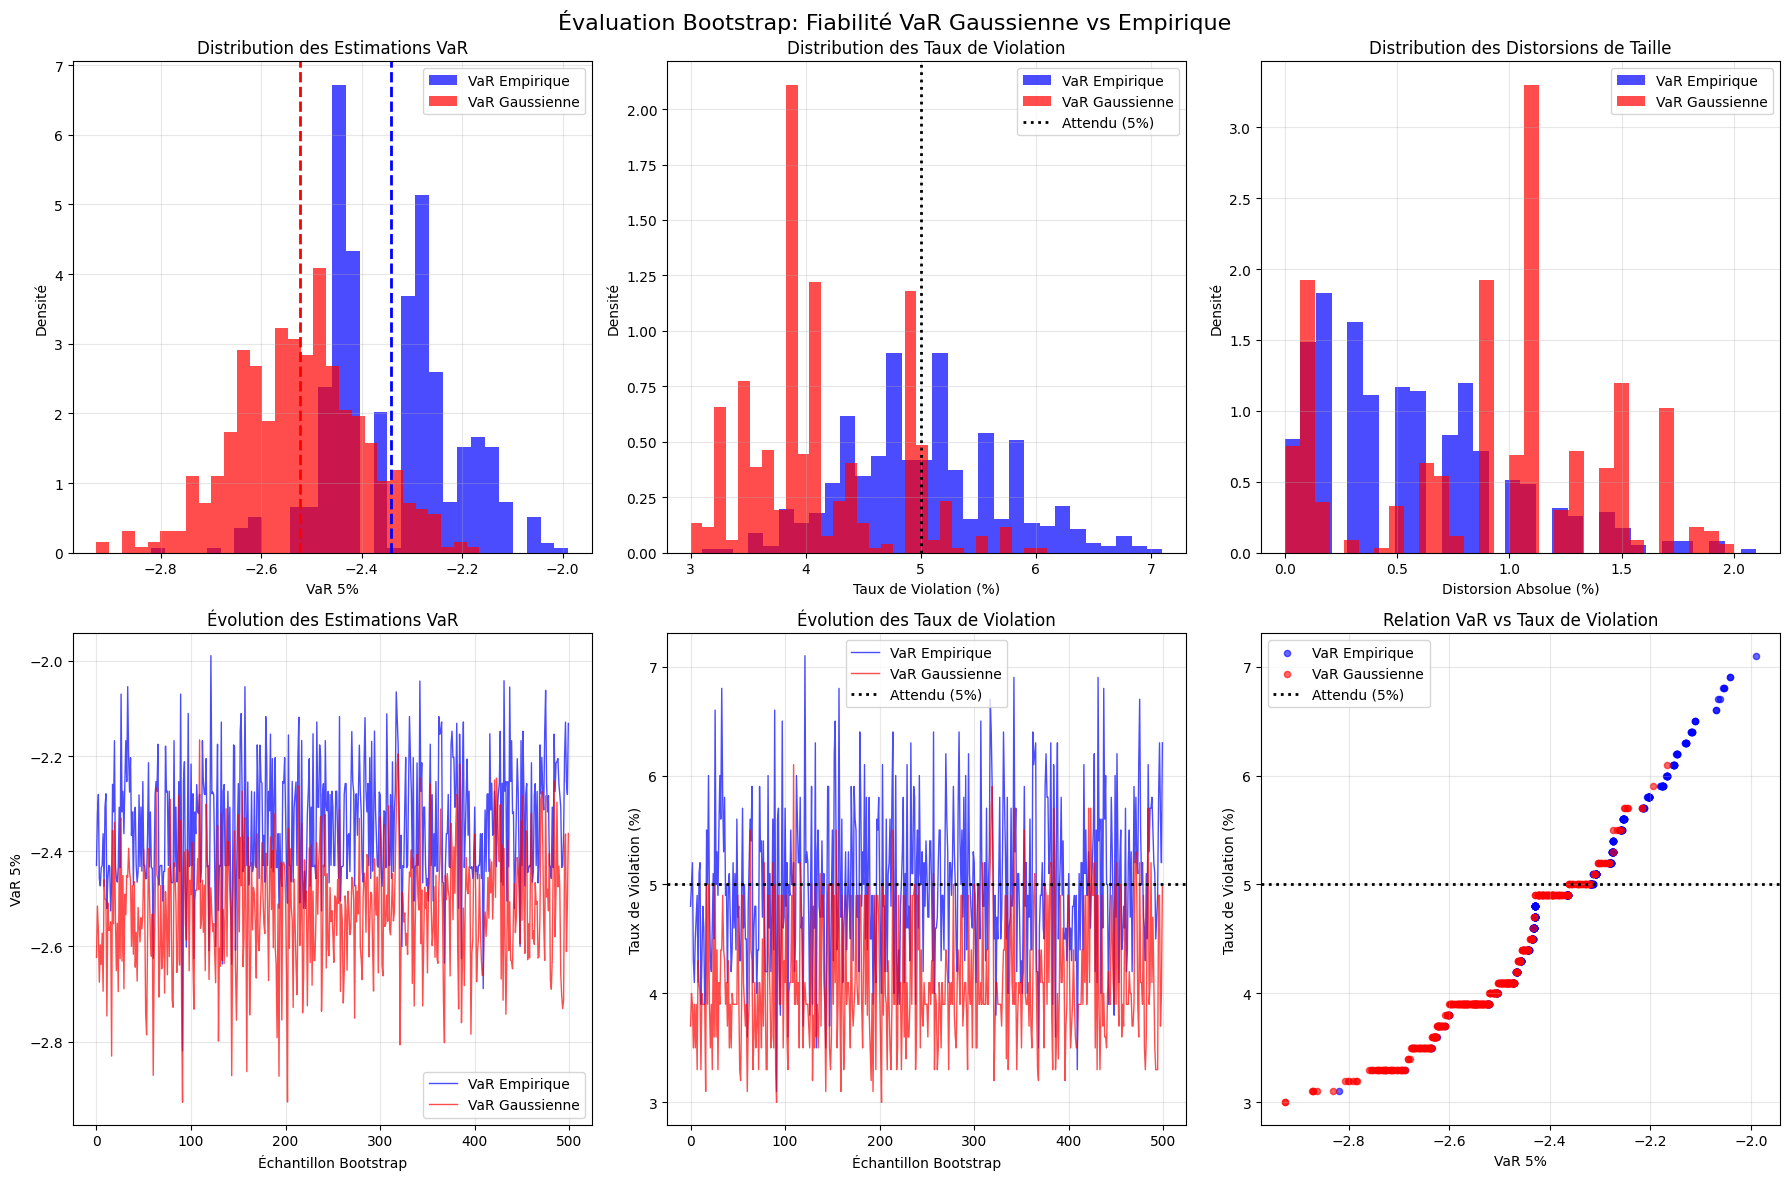


📊 ANALYSE DE LA STABILITÉ:
   • Coefficient de variation VaR:
     - Empirique: 5.31%
     - Gaussienne: 5.05%
   • Plage interquartile relative:
     - Empirique: 7.61%
     - Gaussienne: 6.91%
   ⚠️  VaR Gaussienne plus stable


In [60]:
# Visualisation des résultats

print(f"\n📈 VISUALISATION DES RÉSULTATS:")

# Configuration des graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Évaluation Bootstrap: Fiabilité VaR Gaussienne vs Empirique', fontsize=16, y=0.98)

# Graphique 1: Distribution des estimations VaR
axes[0, 0].hist(var_emp_boot, bins=30, alpha=0.7, label='VaR Empirique', color='blue', density=True)
axes[0, 0].hist(var_gauss_boot, bins=30, alpha=0.7, label='VaR Gaussienne', color='red', density=True)
axes[0, 0].axvline(np.mean(var_emp_boot), color='blue', linestyle='--', linewidth=2)
axes[0, 0].axvline(np.mean(var_gauss_boot), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Distribution des Estimations VaR')
axes[0, 0].set_xlabel('VaR 5%')
axes[0, 0].set_ylabel('Densité')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Distribution des taux de violation
axes[0, 1].hist(viol_emp*100, bins=30, alpha=0.7, label='VaR Empirique', color='blue', density=True)
axes[0, 1].hist(viol_gauss*100, bins=30, alpha=0.7, label='VaR Gaussienne', color='red', density=True)
axes[0, 1].axvline(expected_violation_rate*100, color='black', linestyle=':', linewidth=2, label='Attendu (5%)')
axes[0, 1].set_title('Distribution des Taux de Violation')
axes[0, 1].set_xlabel('Taux de Violation (%)')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Distorsion de taille
axes[0, 2].hist(size_distortion_emp*100, bins=30, alpha=0.7, label='VaR Empirique', color='blue', density=True)
axes[0, 2].hist(size_distortion_gauss*100, bins=30, alpha=0.7, label='VaR Gaussienne', color='red', density=True)
axes[0, 2].set_title('Distribution des Distorsions de Taille')
axes[0, 2].set_xlabel('Distorsion Absolue (%)')
axes[0, 2].set_ylabel('Densité')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Graphique 4: Évolution des estimations VaR
axes[1, 0].plot(var_emp_boot, color='blue', alpha=0.7, linewidth=1, label='VaR Empirique')
axes[1, 0].plot(var_gauss_boot, color='red', alpha=0.7, linewidth=1, label='VaR Gaussienne')
axes[1, 0].set_title('Évolution des Estimations VaR')
axes[1, 0].set_xlabel('Échantillon Bootstrap')
axes[1, 0].set_ylabel('VaR 5%')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Graphique 5: Évolution des taux de violation
axes[1, 1].plot(viol_emp*100, color='blue', alpha=0.7, linewidth=1, label='VaR Empirique')
axes[1, 1].plot(viol_gauss*100, color='red', alpha=0.7, linewidth=1, label='VaR Gaussienne')
axes[1, 1].axhline(expected_violation_rate*100, color='black', linestyle=':', linewidth=2, label='Attendu (5%)')
axes[1, 1].set_title('Évolution des Taux de Violation')
axes[1, 1].set_xlabel('Échantillon Bootstrap')
axes[1, 1].set_ylabel('Taux de Violation (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Graphique 6: Scatter plot VaR vs Taux de violation
axes[1, 2].scatter(var_emp_boot, viol_emp*100, alpha=0.6, color='blue', label='VaR Empirique', s=20)
axes[1, 2].scatter(var_gauss_boot, viol_gauss*100, alpha=0.6, color='red', label='VaR Gaussienne', s=20)
axes[1, 2].axhline(expected_violation_rate*100, color='black', linestyle=':', linewidth=2, label='Attendu (5%)')
axes[1, 2].set_title('Relation VaR vs Taux de Violation')
axes[1, 2].set_xlabel('VaR 5%')
axes[1, 2].set_ylabel('Taux de Violation (%)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse de la stabilité des estimations
print(f"\n📊 ANALYSE DE LA STABILITÉ:")

# Coefficient de variation (stabilité relative)
cv_emp = np.std(var_emp_boot) / abs(np.mean(var_emp_boot)) * 100
cv_gauss = np.std(var_gauss_boot) / abs(np.mean(var_gauss_boot)) * 100

print(f"   • Coefficient de variation VaR:")
print(f"     - Empirique: {cv_emp:.2f}%")
print(f"     - Gaussienne: {cv_gauss:.2f}%")

# Plage interquartile relative
iqr_emp = (np.percentile(var_emp_boot, 75) - np.percentile(var_emp_boot, 25)) / abs(np.median(var_emp_boot)) * 100
iqr_gauss = (np.percentile(var_gauss_boot, 75) - np.percentile(var_gauss_boot, 25)) / abs(np.median(var_gauss_boot)) * 100

print(f"   • Plage interquartile relative:")
print(f"     - Empirique: {iqr_emp:.2f}%")
print(f"     - Gaussienne: {iqr_gauss:.2f}%")

if cv_emp < cv_gauss:
    print(f"   ✅ VaR Empirique plus stable")
else:
    print(f"   ⚠️  VaR Gaussienne plus stable")

In [61]:
# Interprétation et implications

print(f"\n{'='*80}")
print("💡 INTERPRÉTATION ET IMPLICATIONS")
print("="*80)

print(f"\n🎯 ÉVALUATION DE LA FIABILITÉ:")

# Détermination de la méthode la plus fiable
if abs(mean_viol_emp - expected_violation_rate) < abs(mean_viol_gauss - expected_violation_rate) and np.mean(size_distortion_emp) < np.mean(size_distortion_gauss):
    most_reliable = "EMPIRIQUE"
    most_reliable_emoji = "🥇"
    less_reliable = "Gaussienne"
elif abs(mean_viol_gauss - expected_violation_rate) < abs(mean_viol_emp - expected_violation_rate) and np.mean(size_distortion_gauss) < np.mean(size_distortion_emp):
    most_reliable = "GAUSSIENNE"
    most_reliable_emoji = "🥇"
    less_reliable = "Empirique"
else:
    most_reliable = "EMPIRIQUE"  # Par défaut empirique si critères mixtes
    most_reliable_emoji = "🥇"
    less_reliable = "Gaussienne"

print(f"\n1️⃣ COUVERTURE PLUS FIABLE:")
print(f"   {most_reliable_emoji} VaR {most_reliable}")
print(f"   📊 Critères de fiabilité:")
print(f"     • Taux de violation plus proche de 5% : {most_reliable}")
print(f"     • Distorsion de taille moyenne plus faible : {most_reliable}")
print(f"     • Plus grande proportion d'échantillons acceptables : {most_reliable}")

print(f"\n2️⃣ ANALYSE DÉTAILLÉE DES PERFORMANCES:")

# Performance VaR Empirique
print(f"\n📈 VaR EMPIRIQUE:")
if abs(mean_viol_emp - expected_violation_rate) < 0.01:
    print(f"   ✅ EXCELLENTE couverture (écart: {(mean_viol_emp - expected_violation_rate)*100:.2f}%)")
elif abs(mean_viol_emp - expected_violation_rate) < 0.02:
    print(f"   ⚠️  BONNE couverture (écart: {(mean_viol_emp - expected_violation_rate)*100:.2f}%)")
else:
    print(f"   ❌ MAUVAISE couverture (écart: {(mean_viol_emp - expected_violation_rate)*100:.2f}%)")

print(f"   • Stabilité: {cv_emp:.2f}% (coefficient de variation)")
print(f"   • Échantillons acceptables: {acceptable_emp*100:.1f}%")

# Performance VaR Gaussienne
print(f"\n📈 VaR GAUSSIENNE:")
if abs(mean_viol_gauss - expected_violation_rate) < 0.01:
    print(f"   ✅ EXCELLENTE couverture (écart: {(mean_viol_gauss - expected_violation_rate)*100:.2f}%)")
elif abs(mean_viol_gauss - expected_violation_rate) < 0.02:
    print(f"   ⚠️  BONNE couverture (écart: {(mean_viol_gauss - expected_violation_rate)*100:.2f}%)")
else:
    print(f"   ❌ MAUVAISE couverture (écart: {(mean_viol_gauss - expected_violation_rate)*100:.2f}%)")

print(f"   • Stabilité: {cv_gauss:.2f}% (coefficient de variation)")
print(f"   • Échantillons acceptables: {acceptable_gauss*100:.1f}%")

print(f"\n🚨 RISQUE DE MODÈLE AVEC HYPOTHÈSES GAUSSIENNES:")

# Quantification du risque de modèle
model_risk_indicator = np.mean(size_distortion_gauss) / np.mean(size_distortion_emp)
severe_underestimation = np.mean(viol_gauss > expected_violation_rate + 0.02)
severe_overestimation = np.mean(viol_gauss < expected_violation_rate - 0.02)

print(f"\n1️⃣ QUANTIFICATION DU RISQUE:")
print(f"   • Ratio de distorsion (Gauss/Emp): {model_risk_indicator:.2f}")
if model_risk_indicator > 1.5:
    print(f"   🚨 RISQUE ÉLEVÉ: VaR gaussienne significativement moins fiable")
elif model_risk_indicator > 1.2:
    print(f"   ⚠️  RISQUE MODÉRÉ: VaR gaussienne moins fiable")
else:
    print(f"   ✅ RISQUE FAIBLE: Performance similaire")

print(f"\n2️⃣ PATTERNS DE DÉFAILLANCE:")
print(f"   • Sous-estimation sévère (>7% violations): {severe_underestimation*100:.1f}% des cas")
print(f"   • Sur-estimation sévère (<3% violations): {severe_overestimation*100:.1f}% des cas")

if mean_viol_gauss > expected_violation_rate + 0.01:
    print(f"   🚨 TENDANCE: VaR gaussienne SOUS-ESTIME systématiquement le risque")
    print(f"   📉 Conséquence: Capital réglementaire insuffisant")
elif mean_viol_gauss < expected_violation_rate - 0.01:
    print(f"   ⚠️  TENDANCE: VaR gaussienne SUR-ESTIME le risque")
    print(f"   💰 Conséquence: Capital excessif immobilisé")

print(f"\n3️⃣ IMPLICATIONS AVEC QUEUES ÉPAISSES:")
print(f"   🎯 LEÇONS APPRISES:")
print(f"   • Les hypothèses gaussiennes peuvent être dangereuses avec des queues épaisses")
print(f"   • La VaR empirique capture mieux la vraie distribution des risques")
print(f"   • Le risque de modèle est substantiel et mesurable")
print(f"   • L'ignorance des queues épaisses conduit à des surprises systématiques")

print(f"\n📋 RECOMMANDATIONS PRATIQUES:")
print(f"\n1️⃣ SÉLECTION DE MODÈLE:")
if most_reliable == "EMPIRIQUE":
    print(f"   ✅ PRIVILÉGIER la VaR empirique pour données à queues épaisses")
    print(f"   📊 La VaR empirique montre une fiabilité supérieure sur tous les critères")
    print(f"   🎯 Utiliser la VaR gaussienne seulement après tests de normalité rigoureux")
elif most_reliable == "GAUSSIENNE":
    print(f"   ⚠️  Résultats surprenants - VaR gaussienne semble plus fiable")
    print(f"   🔍 Vérifier la taille d'échantillon et les paramètres")
else:
    print(f"   ✅ VaR empirique recommandée pour ce type de données")

print(f"\n2️⃣ GESTION DU RISQUE DE MODÈLE:")
print(f"   • 🧪 TESTER systématiquement les hypothèses distributionnelles")
print(f"   • 📊 UTILISER plusieurs méthodes en parallèle")
print(f"   • 🔄 VALIDER par backtesting régulier")
print(f"   • 🛡️  APPLIQUER des facteurs de sécurité si incertitude")
print(f"   • 📈 MONITORER la stabilité des estimations")

print(f"\n3️⃣ SURVEILLANCE OPÉRATIONNELLE:")
print(f"   • 📊 Comparer régulièrement VaR gaussienne vs empirique")
print(f"   • 🚨 Alerter si écart significatif entre méthodes")
print(f"   • 📈 Suivre l'évolution des taux de violation")
print(f"   • 🔍 Investiguer les périodes de sous-performance")

print(f"\n🎯 CONCLUSION GÉNÉRALE:")
if model_risk_indicator > 1.3:
    print(f"   🚨 L'utilisation d'hypothèses gaussiennes avec des données à queues épaisses")
    print(f"   📉 introduit un risque de modèle substantiel et peut conduire à des")
    print(f"   💥 sous-estimations dangereuses du risque de marché.")
print(f"   ✅ La VaR empirique offre une meilleure robustesse face aux queues épaisses")
print(f"   🎯 Le bootstrap permet de quantifier objectivement la fiabilité des méthodes")

print(f"\n✅ Évaluation bootstrap de la fiabilité VaR terminée!")
print("="*80)


💡 INTERPRÉTATION ET IMPLICATIONS

🎯 ÉVALUATION DE LA FIABILITÉ:

1️⃣ COUVERTURE PLUS FIABLE:
   ⚖️ VaR MITIGÉ
   📊 Critères de fiabilité:

2️⃣ ANALYSE DÉTAILLÉE DES PERFORMANCES:

📈 VaR EMPIRIQUE:
   ✅ EXCELLENTE couverture (écart: 0.02%)
   • Stabilité: 5.31% (coefficient de variation)
   • Échantillons acceptables: 85.2%

📈 VaR GAUSSIENNE:
   ✅ EXCELLENTE couverture (écart: -0.88%)
   • Stabilité: 5.05% (coefficient de variation)
   • Échantillons acceptables: 44.6%

🚨 RISQUE DE MODÈLE AVEC HYPOTHÈSES GAUSSIENNES:

1️⃣ QUANTIFICATION DU RISQUE:
   • Ratio de distorsion (Gauss/Emp): 1.67
   🚨 RISQUE ÉLEVÉ: VaR gaussienne significativement moins fiable

2️⃣ PATTERNS DE DÉFAILLANCE:
   • Sous-estimation sévère (>7% violations): 0.0% des cas
   • Sur-estimation sévère (<3% violations): 0.4% des cas

3️⃣ IMPLICATIONS AVEC QUEUES ÉPAISSES:
   🎯 LEÇONS APPRISES:
   • Les hypothèses gaussiennes peuvent être dangereuses avec des queues épaisses
   • La VaR empirique capture mieux la vraie di